In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import site
import sys
import itertools
from operator import itemgetter
from scipy.spatial import cKDTree, distance
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import unary_union
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import seaborn as sns 
from scipy import stats
import contextily as cx
from math import sin, cos, acos, pi
import networkx as nx

sns.set()

## Initilization (documents)

<AxesSubplot:>

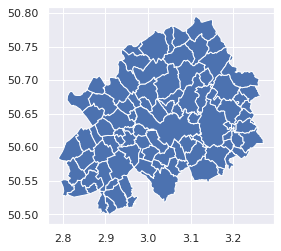

In [3]:
mel_cities = gpd.read_file('mel_communes.zip')
mel_cities.plot()

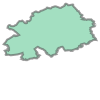

In [4]:
mel_boundary = mel_cities.geometry.unary_union
mel_boundary

In [5]:
dfe = gpd.read_parquet('mel.parquet')

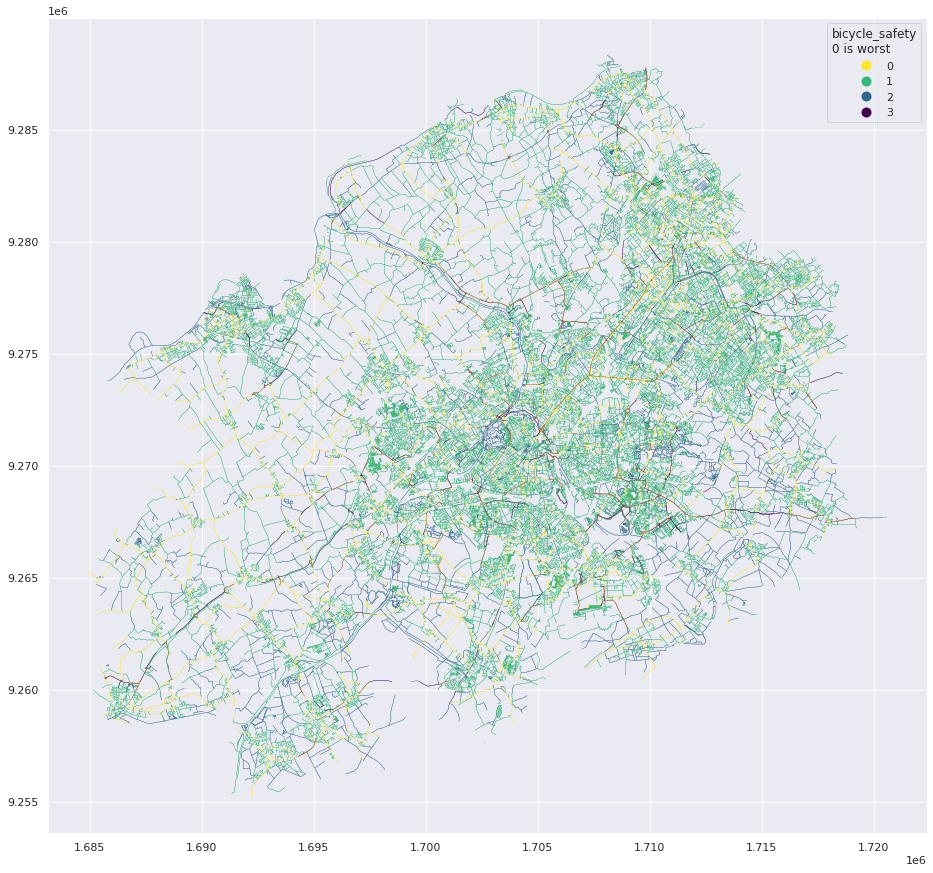

In [6]:
ax = dfe[dfe.bicycle == 1].plot(column='bicycle_safety', cmap='viridis_r', categorical=True, linewidth=0.3, figsize=(20,15), legend= True)
fig = ax.get_figure()
ax.get_legend().set_title('bicycle_safety\n0 is worst')


In [7]:
average_speed_kph = 15
average_speed_mps = average_speed_kph * 1000 / 3600
dfe['time'] = dfe.length / average_speed_mps

In [8]:
irises = gpd.read_file('IRIS-GE_2-0_SHP_LAMB93_D059-2020/IRIS_GE.SHP')
irises = irises.to_crs(3950)

In [9]:
mel_boundary = gpd.read_file('mel_boundary.geojson')
mel_boundary = mel_boundary.to_crs(3950)
mel_boundary.geometry = mel_boundary.geometry.apply(lambda g: g.buffer(-200))

In [10]:
irisMEL = gpd.sjoin(irises,mel_boundary, predicate='intersects')
irisMEL

INSEE_COM              NOM_COM  IRIS  CODE_IRIS             NOM_IRIS  \
3        59350                Lille  0302  593500302     Vauban-Esquermes   
15       59332               Lannoy  0000  593320000               Lannoy   
21       59220     Faches-Thumesnil  0101  592200101       Thumesnil Nord   
29       59670                  Don  0000  596700000                  Don   
34       59005  Allennes-les-Marais  0000  590050000  Allennes-les-Marais   
...        ...                  ...   ...        ...                  ...   
1182     59650            Wattrelos  0605  596500605           Beaulieu 3   
1183     59650            Wattrelos  0603  596500603           Beaulieu 1   
1184     59339                Leers  0101  593390101               Centre   
1185     59339                Leers  0103  593390103                  Est   
1186     59650            Wattrelos  0601  596500601            Baillerie   

     TYP_IRIS                                           geometry  index_right  \
3           A  POLYGON ((1703308.607 9270684.688, 1703285.147...            0   
15          Z  POLYGON ((1714551.261 9274142.484, 1714578.710...            0   
21          H  POLYGON ((1704177.345 9267517.720, 1704192.318...            0   
29          Z  POLYGON ((1695106.043 9260913.988, 1695103.048...            0   
34          Z  POLYGON ((1697382.891 9258731.122, 1697324.882...            0   
...       ...                                                ...          ...   
1182        H  POLYGON ((1716233.572 9278055.299, 1716214.207...            0   
1183        H  POLYGON ((1716673.453 9278235.548, 1716672.555...            0   
1184        H  POLYGON ((1716885.210 9275060.336, 1716871.530...            0   
1185        H  POLYGON ((1716626.035 9274653.010, 1716630.225...            0   
1186        H  POLYGON ((1716382.497 9278712.742, 1716360.635...            0   

              name  
3     mel_boundary  
15    mel_boundary  
21    mel_boundary  
29    mel_boundary  
34    mel_boundary  
...            ...  
1182  mel_boundary  
1183  mel_boundary  
1184  mel_boundary  
1185  mel_boundary  
1186  mel_boundary  

[517 rows x 9 columns]

<AxesSubplot:>

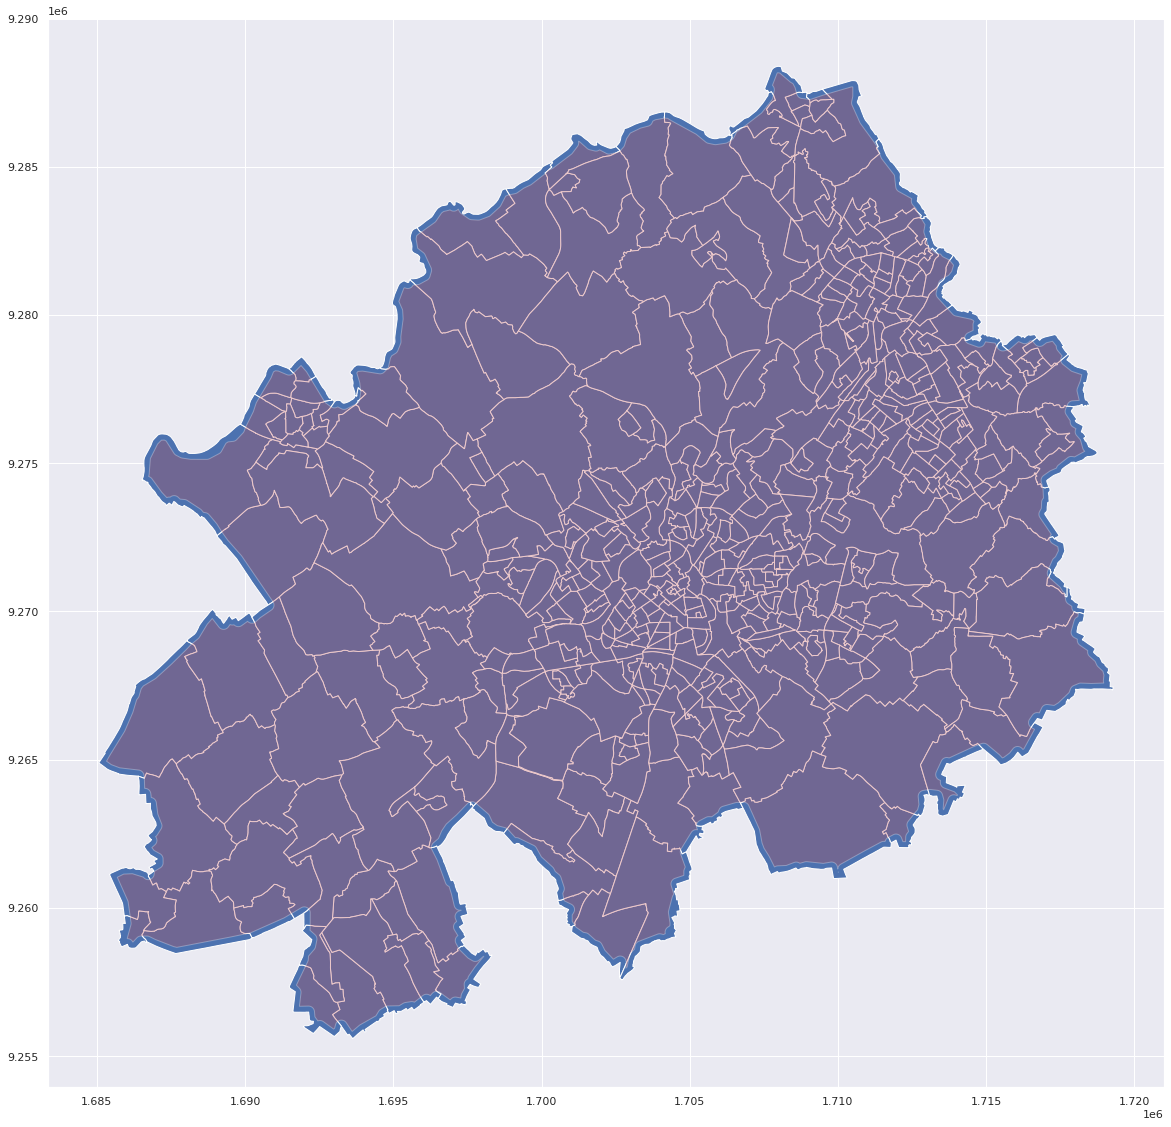

In [11]:
ax = irisMEL.plot(figsize=(20,20))
mel_boundary.plot(ax=ax,color='r',alpha=0.3)

<AxesSubplot:>

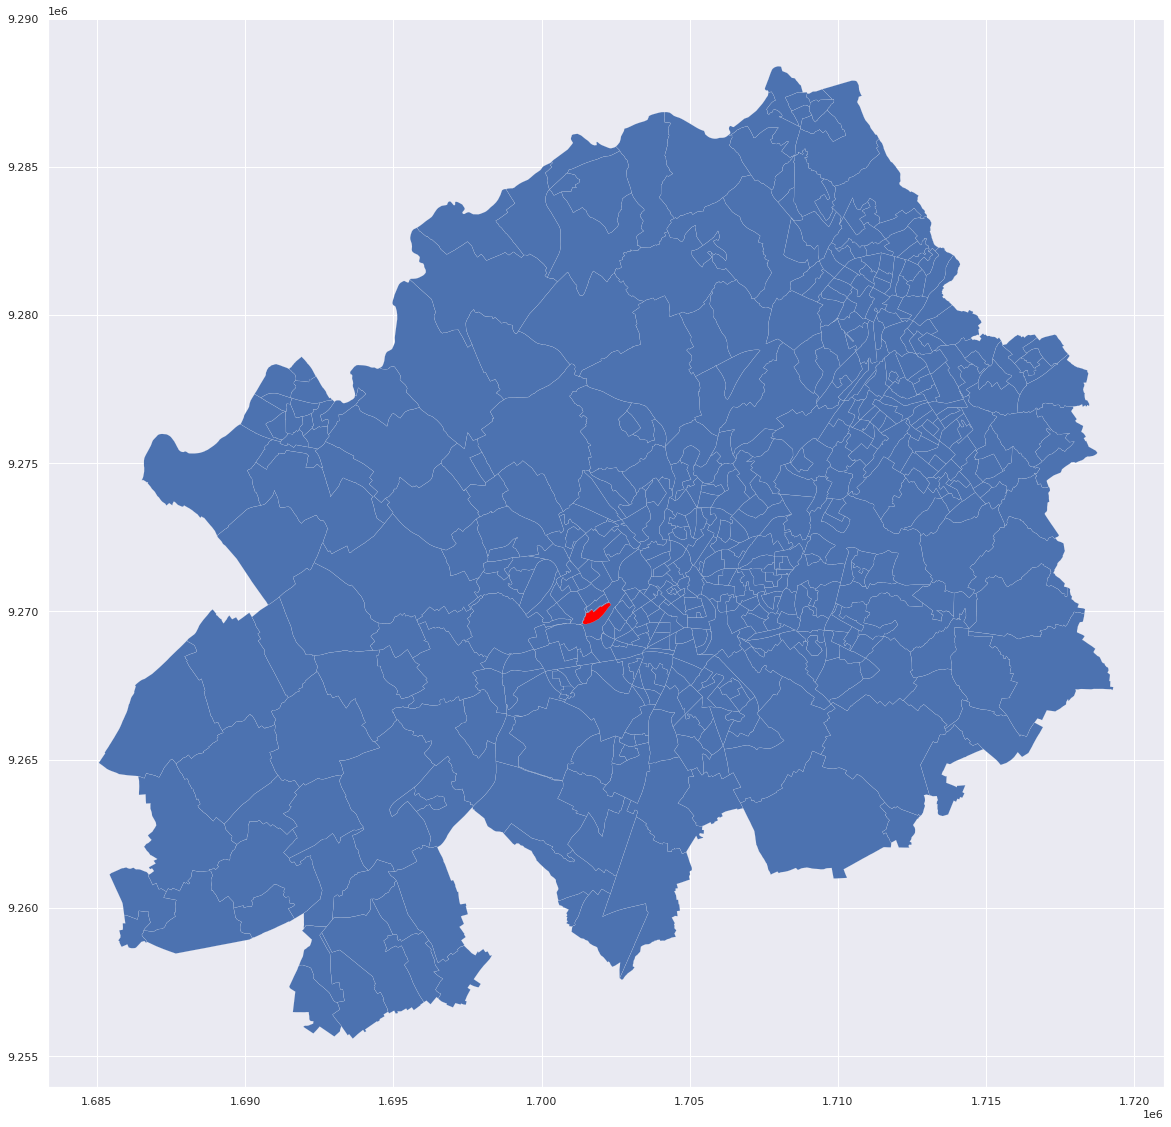

In [12]:
iris = irisMEL[irisMEL.IRIS == '0804'].copy(deep=True)
ax = irisMEL.plot(linewidth=0.1,figsize=(20,20))
iris.plot(ax=ax, color='red', linewidth=0.1)

## Find the best irises (NIELS)

In [13]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
data_frame = pd.read_excel('emploisMEL.xlsx',sheet_name='iris_et_commune1')
data_frame['geometry'] = data_frame['geometry'].apply(lambda x: loads(x))
iris_emploi = gpd.GeoDataFrame(data_frame, geometry='geometry', crs='EPSG:3950')
iris_emploi



Unnamed: 0  CODE_IRIS  INSEE_COM      NOM_COM  IRIS  CODE_IRIS.1  \
0           118  593500101      59350        Lille   101    593500101   
1           927  593500117      59350        Lille   117    593500117   
2           920  593500109      59350        Lille   109    593500109   
3           122  593500107      59350        Lille   107    593500107   
4           848  593500112      59350        Lille   112    593500112   
..          ...        ...        ...          ...   ...          ...   
511          99  593710000      59371   Le Maisnil     0    593710000   
512          93  592570000      59257    Fromelles     0    592570000   
513          95  596580000      59658       Wicres     0    596580000   
514        1092  595120202      59512      Roubaix   202    595120202   
515         104  592080000      59208  Escobecques     0    592080000   

            NOM_IRIS TYP_IRIS  \
0     Lille Centre 1        A   
1    Lille Centre 17        H   
2     Lille Centre 9        A   
3     Lille Centre 7        A   
4    Lille Centre 12        H   
..               ...      ...   
511       Le Maisnil        Z   
512        Fromelles        Z   
513           Wicres        Z   
514         Alma Sud        H   
515      Escobecques        Z   

                                              geometry  tag  emplois  \
0    POLYGON ((704367.500 7059424.300, 704293.300 7...    1   2409.5   
1    POLYGON ((704878.400 7059147.300, 704873.100 7...    1  14814.0   
2    POLYGON ((704448.600 7059886.700, 704443.000 7...    1   1497.0   
3    POLYGON ((704318.100 7059752.100, 704304.000 7...    1    945.0   
4    POLYGON ((703977.000 7059882.100, 703957.700 7...    1   7917.5   
..                                                 ...  ...      ...   
511  POLYGON ((692372.700 7057081.900, 692299.000 7...    0     68.0   
512  POLYGON ((688020.600 7058166.300, 688050.500 7...    0    153.0   
513  POLYGON ((691824.700 7053205.000, 691820.200 7...    0     49.0   
514  POLYGON ((711891.700 7066869.100, 711868.200 7...    1      1.5   
515  POLYGON ((694305.700 7057836.900, 694293.000 7...    0     26.0   

     surface_emplois  densite_emplois   population  surface_iris  \
0       2.630304e+04     91605.368266    40.708698  2.630304e+04   
1       2.106190e+05     70335.545274  1880.500673  2.106190e+05   
2       3.852916e+04     38853.686076   142.786390  3.852916e+04   
3       2.616650e+04     36114.877123   126.029979  2.616650e+04   
4       2.349588e+05     33697.392895  2556.552093  2.349588e+05   
..               ...              ...          ...           ...   
511     3.525456e+06        19.288285   642.000000  3.514215e+06   
512     8.693980e+06        17.598385   958.000000  8.666375e+06   
513     2.827035e+06        17.332649   498.000000  2.812485e+06   
514     9.338749e+04        16.062109  1802.635955  9.338749e+04   
515     1.856200e+06        14.007109   299.000000  1.850004e+06   

     population_densite  
0           1547.680122  
1           8928.448780  
2           3705.930237  
3           4816.462668  
4          10880.851321  
..                  ...  
511          182.686602  
512          110.542178  
513          177.067639  
514        19302.757018  
515          161.621309  

[516 rows x 16 columns]

<AxesSubplot:>

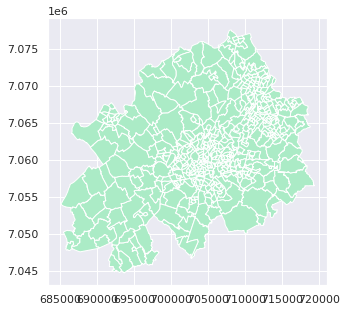

In [14]:
iris_emploi = iris_emploi.to_crs(3950)
iris_emploi.plot(color='#ABEBC6',figsize=(5, 5))


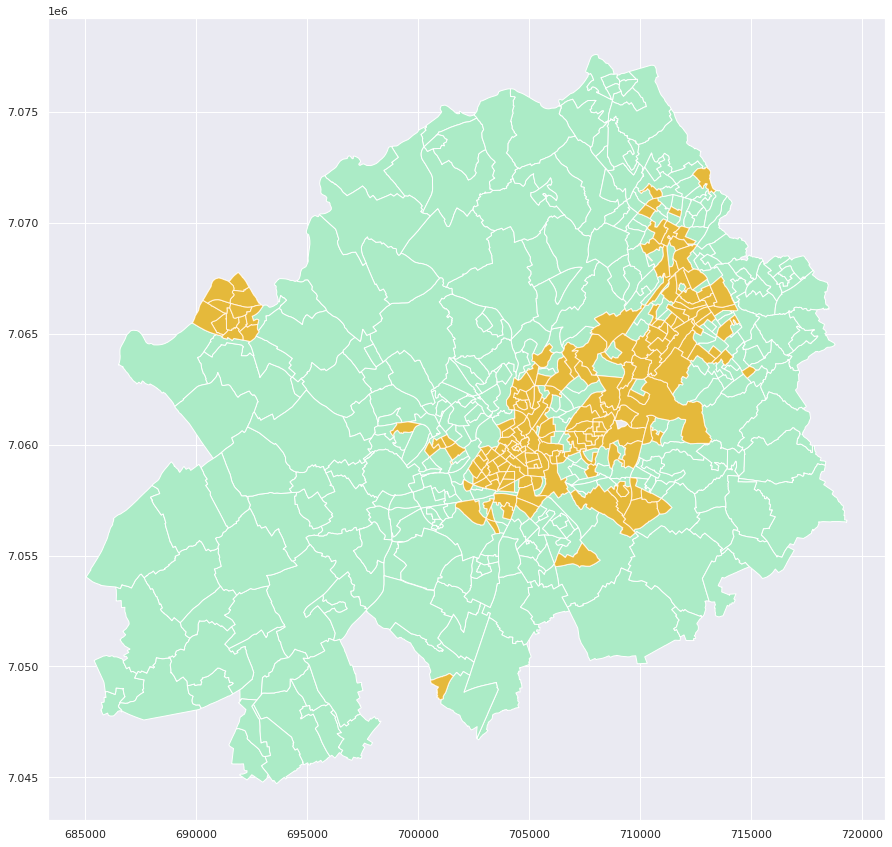

In [15]:
emplois_data = iris_emploi[iris_emploi['densite_emplois'] >=1500 ]

emplois_df = gpd.GeoDataFrame(emplois_data, geometry='geometry', crs=iris_emploi.crs)
#population_df = gpd.GeoDataFrame(population_data, geometry='geometry', crs=iris_emploi.crs)


fig, ax = plt.subplots(figsize=(15, 15))
iris_emploi.plot(ax=ax, color='#ABEBC6')
emplois_df.plot(ax=ax, color='orange', edgecolor='white', alpha=0.7)

#population_df.plot(ax=ax, color='blue', edgecolor='white', alpha=0.7)


plt.show()

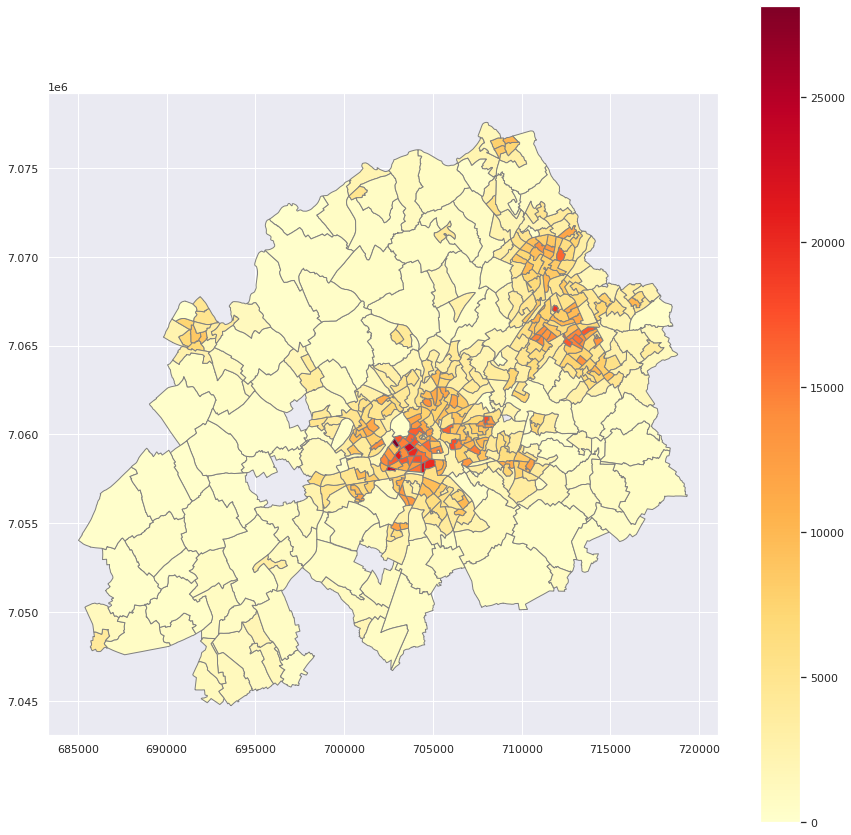

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
iris_emploi.plot(ax=ax,cmap='YlOrRd',categorical=False, edgecolor='gray', column='population_densite',legend=set(iris_emploi.population_densite.values))
plt.show()

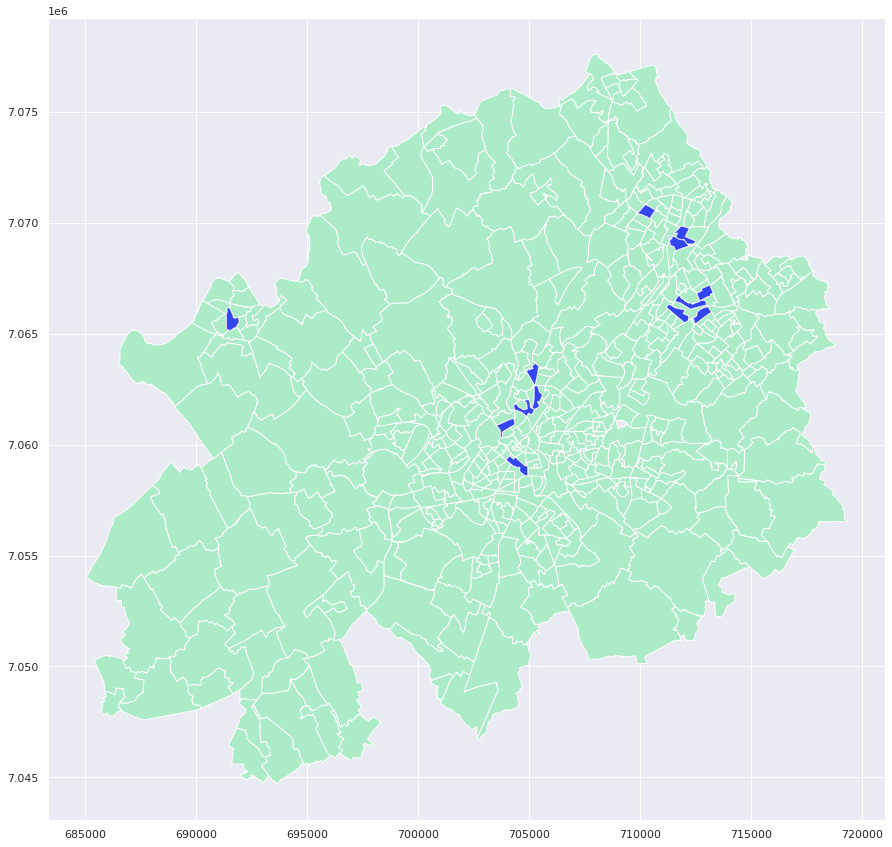

In [17]:
iris_parf = iris_emploi[iris_emploi['densite_emplois'] >=1575]
iris_parf = iris_parf[iris_parf['population_densite'] >=8000]
iris_parf = iris_parf[iris_parf['population_densite'] <= 13000]
iris_parf = iris_parf[iris_parf['surface_iris'] >= 2.5e+05]


emplois_df = gpd.GeoDataFrame(emplois_data, geometry='geometry', crs=iris_emploi.crs)
iris_parf_df = gpd.GeoDataFrame(iris_parf, geometry='geometry', crs=iris_emploi.crs)


fig, ax = plt.subplots(figsize=(15, 15))
iris_emploi.plot(ax=ax, color='#ABEBC6')
iris_parf_df.plot(ax=ax, color='blue', edgecolor='white', alpha=0.7)

plt.show()

In [18]:
iris_parf

Unnamed: 0  CODE_IRIS  INSEE_COM          NOM_COM  IRIS  CODE_IRIS.1  \
26          845  593500119      59350            Lille   119    593500119   
29         1098  595120602      59512          Roubaix   602    595120602   
40         1116  595120603      59512          Roubaix   603    595120603   
62          839  593500205      59350            Lille   205    593500205   
64         1094  595990503      59599        Tourcoing   503    595990503   
68          986  593680202      59368     La Madeleine   202    593680202   
70          981  593680301      59368     La Madeleine   301    593680301   
91         1148  595120402      59512          Roubaix   402    595120402   
97          985  593780202      59378  Marcq-en-Barœul   202    593780202   
112        1066  595991001      59599        Tourcoing  1001    595991001   
117        1096  595990801      59599        Tourcoing   801    595990801   
119        1091  595120504      59512          Roubaix   504    595120504   
149         729  590170402      59017      Armentières   402    590170402   

                          NOM_IRIS TYP_IRIS  \
26                 Lille Centre 19        H   
29                   Nations Unies        H   
40                         Anseele        H   
62                   Vieux Lille 5        H   
64                            Gare        H   
68                        Centre 2        H   
70   Pompidou-Nouvelle Madeleine 1        H   
91                 Hommelet Centre        H   
97                   Pont de Marcq        H   
112                    Belencontre        H   
117                Tilleul-Guisnes        H   
119                        Trichon        H   
149            Centre République 2        H   

                                              geometry  tag  emplois  \
26   POLYGON ((704013.800 7059254.700, 703990.200 7...    1   3245.0   
29   POLYGON ((711569.500 7066473.000, 711577.000 7...    1   2769.0   
40   POLYGON ((712492.100 7065435.200, 712474.500 7...    1   1632.5   
62   POLYGON ((703715.200 7060315.500, 703713.900 7...    1    986.5   
64   POLYGON ((711604.900 7068723.400, 711588.500 7...    1   1154.0   
68   POLYGON ((705288.100 7061588.700, 705283.000 7...    0   8723.0   
70   POLYGON ((704340.200 7061556.200, 704339.100 7...    0   8723.0   
91   POLYGON ((712686.900 7066468.200, 712677.400 7...    1    720.0   
97   POLYGON ((705231.000 7062698.800, 705227.800 7...    1    678.0   
112  POLYGON ((709894.900 7070430.700, 709899.400 7...    1    544.0   
117  POLYGON ((711608.900 7069334.800, 711627.300 7...    1    713.0   
119  POLYGON ((711448.400 7065953.800, 711412.600 7...    1    661.5   
149  POLYGON ((691443.100 7065155.100, 691429.600 7...    0   9915.0   

     surface_emplois  densite_emplois   population   surface_iris  \
26      3.445714e+05      9417.495559  4364.514578  344571.439385   
29      3.194932e+05      8666.852080  3242.420356  319493.164821   
40      2.875981e+05      5676.323453  2709.711080  287598.128196   
62      2.740275e+05      3600.004223  3229.792063  274027.456306   
64      3.284148e+05      3513.849203  2777.604950  328414.776300   
68      2.700218e+06      3230.480441  2753.680877  270994.615290   
70      2.700218e+06      3230.480441  2353.280946  269490.214044   
91      2.823073e+05      2550.412124  2779.427335  282307.315488   
97      2.741228e+05      2473.343975  2602.487572  274122.809738   
112     2.591690e+05      2099.016336  2206.342531  259169.016751   
117     3.500771e+05      2036.694001  2949.236933  350077.134572   
119     3.326303e+05      1988.694415  2818.722916  332630.289928   
149     6.294040e+06      1575.299695  3192.680876  369123.664551   

     population_densite  
26         12666.501279  
29         10148.637633  
40          9421.866187  
62         11786.381215  
64          8457.612599  
68         10161.385952  
70          8732.342857  
91          9845.396074  
97          9493.874568  
112         8513.141573  
117  

In [19]:
iris_parf['CODE_IRIS'] = iris_parf['CODE_IRIS'].astype(int)
liste_codes_iris_parf = iris_parf['CODE_IRIS'].values


In [20]:
newIrise = irisMEL
newIrise['CODE_IRIS'] = newIrise['CODE_IRIS'].astype(int)
irisMEL_parf =  newIrise[newIrise['CODE_IRIS'].isin(liste_codes_iris_parf)]


print(len(irisMEL_parf))
irisMEL_parf

13


INSEE_COM          NOM_COM  IRIS  CODE_IRIS  \
729      59017      Armentières  0402  590170402   
839      59350            Lille  0205  593500205   
845      59350            Lille  0119  593500119   
981      59368     La Madeleine  0301  593680301   
985      59378  Marcq-en-Barœul  0202  593780202   
986      59368     La Madeleine  0202  593680202   
1066     59599        Tourcoing  1001  595991001   
1091     59512          Roubaix  0504  595120504   
1094     59599        Tourcoing  0503  595990503   
1096     59599        Tourcoing  0801  595990801   
1098     59512          Roubaix  0602  595120602   
1116     59512          Roubaix  0603  595120603   
1148     59512          Roubaix  0402  595120402   

                           NOM_IRIS TYP_IRIS  \
729             Centre République 2        H   
839                   Vieux Lille 5        H   
845                 Lille Centre 19        H   
981   Pompidou-Nouvelle Madeleine 1        H   
985                   Pont de Marcq        H   
986                        Centre 2        H   
1066                    Belencontre        H   
1091                        Trichon        H   
1094                           Gare        H   
1096                Tilleul-Guisnes        H   
1098                  Nations Unies        H   
1116                        Anseele        H   
1148                Hommelet Centre        H   

                                               geometry  index_right  \
729   POLYGON ((1691458.251 9275994.422, 1691444.775...            0   
839   POLYGON ((1703708.801 9271162.978, 1703707.502...            0   
845   POLYGON ((1704006.929 9270104.011, 1703983.368...            0   
981   POLYGON ((1704332.671 9272401.559, 1704331.572...            0   
985   POLYGON ((1705221.866 9273542.213, 1705218.671...            0   
986   POLYGON ((1705278.925 9272434.048, 1705273.834...            0   
1066  POLYGON ((1709876.861 9281260.666, 1709881.352...            0   
1091  POLYGON ((1711428.039 9276791.993, 1711392.299...            0   
1094  POLYGON ((1711583.941 9279556.647, 1711567.566...            0   
1096  POLYGON ((1711587.863 9280166.941, 1711606.224...            0   
1098  POLYGON ((1711548.864 9277310.282, 1711556.348...            0   
1116  POLYGON ((1712469.947 9276274.438, 1712452.376...            0   
1148  POLYGON ((1712664.271 9277305.625, 1712654.785...            0   

              name  
729   mel_boundary  
839   mel_boundary  
845   mel_boundary  
981   mel_boundary  
985   mel_boundary  
986   mel_boundary  
1066  mel_boundary  
1091  mel_boundary  
1094  mel_boundary  
1096  mel_boundary  
1098  mel_boundary  
1116  mel_boundary  
1148  mel_boundary

## Find the bicycle roads 15 min away from irises + noise filter (NIELS) with Pierre help

### 15 min away

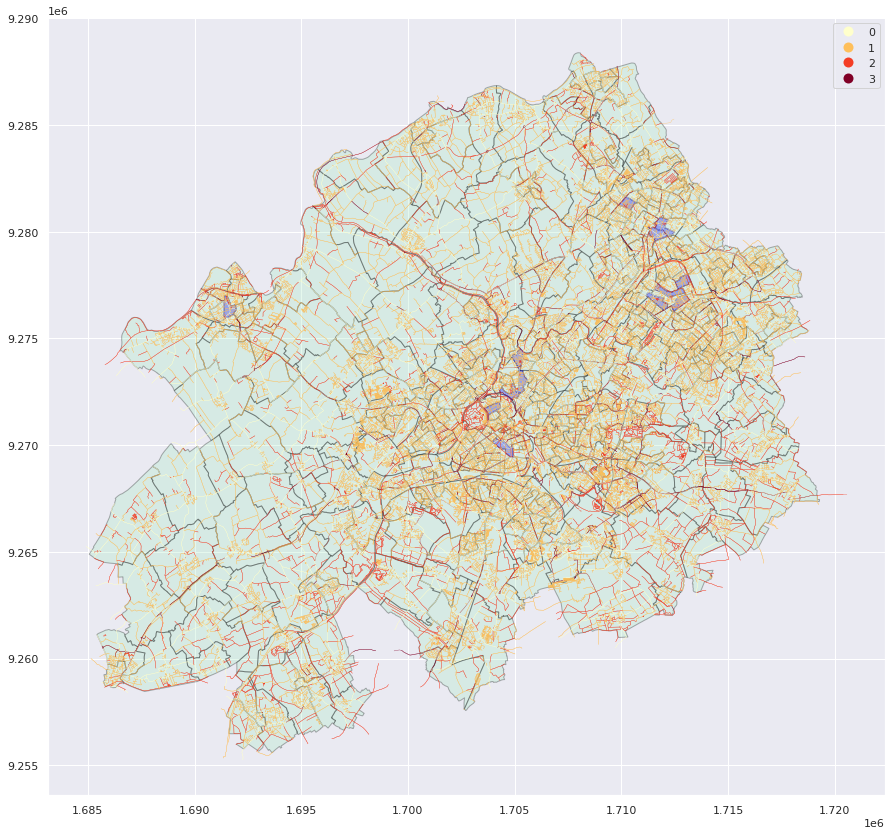

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
irisMEL.plot(ax=ax,color='#ABEBC6',edgecolor='black',alpha=0.3)
dfe[dfe.bicycle == 1].plot(ax=ax,column='bicycle_safety', cmap='YlOrRd', categorical=True, linewidth=0.3, figsize=(20,15), legend= True)
irisMEL_parf.plot(ax=ax,color='blue',edgecolor='blue',alpha=0.3)

plt.show()

<AxesSubplot:>

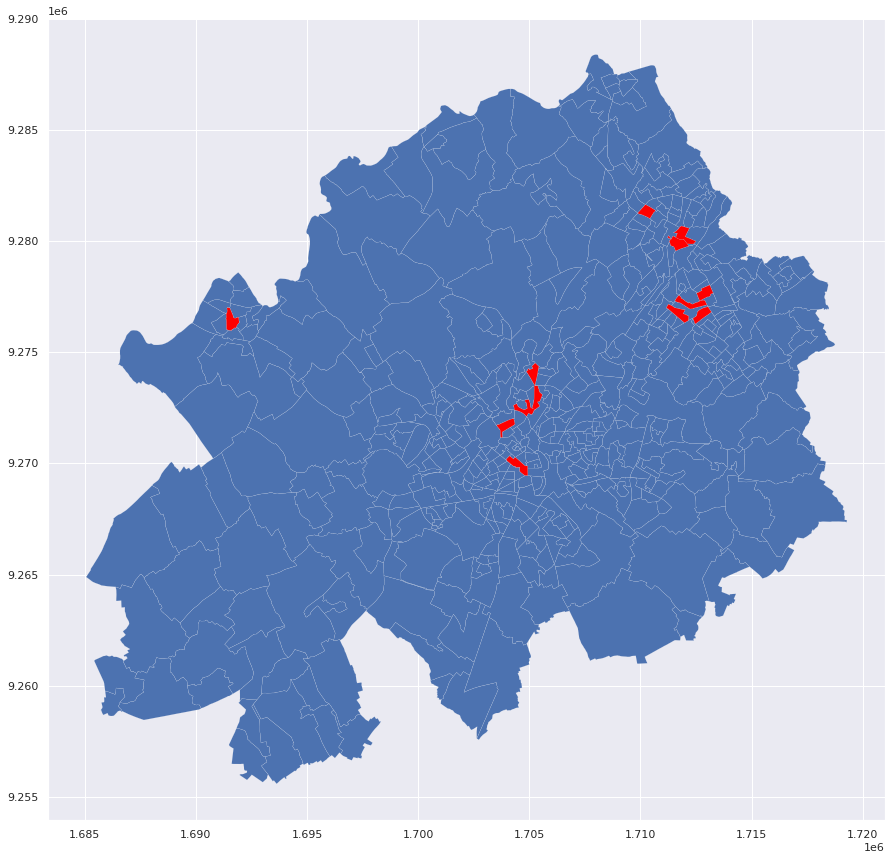

In [22]:
ax = irisMEL.plot(linewidth=0.1,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)

In [23]:
bruit = gpd.read_file('donnees-bruit-nuit.shp')
bruit = bruit.to_crs(3950)
bruit

objectid theme              source  gridcode  from  to period  \
0       948704.0  NUIT               MULTI      55.0   NaN NaN   None   
1       911463.0  NUIT               MULTI      50.0   NaN NaN   None   
2       948880.0  NUIT               MULTI      60.0   NaN NaN   None   
3       949052.0  NUIT               MULTI      50.0   NaN NaN   None   
4       946519.0  NUIT               MULTI       0.0   NaN NaN   None   
...          ...   ...                 ...       ...   ...  ..    ...   
49995  1424393.0  NUIT  MULTI_ZONES_CALMES       0.0   NaN NaN   None   
49996  1425933.0  NUIT  MULTI_ZONES_CALMES       0.0   NaN NaN   None   
49997  1425940.0  NUIT  MULTI_ZONES_CALMES       0.0   NaN NaN   None   
49998  1425949.0  NUIT  MULTI_ZONES_CALMES       0.0   NaN NaN   None   
49999  1426448.0  NUIT  MULTI_ZONES_CALMES       0.0   NaN NaN   None   

                                                geometry  
0      POLYGON ((1705379.456 9274150.461, 1705374.464...  
1      POLYGON ((1709881.206 9277669.566, 1709876.215...  
2      POLYGON ((1697932.530 9274285.101, 1697927.539...  
3      POLYGON ((1710006.340 9274095.913, 1710001.349...  
4      POLYGON ((1697563.180 9274325.039, 1697563.180...  
...                                                  ...  
49995  POLYGON ((1715975.954 9273542.658, 1715970.963...  
49996  POLYGON ((1714353.140 9278089.356, 1714348.148...  
49997  POLYGON ((1713664.143 9279791.191, 1713659.152...  
49998  POLYGON ((1706627.407 9272009.271, 1706622.416...  
49999  POLYGON ((1689462.530 9275443.593, 1689457.539...  

[50000 rows x 8 columns]

<AxesSubplot:>

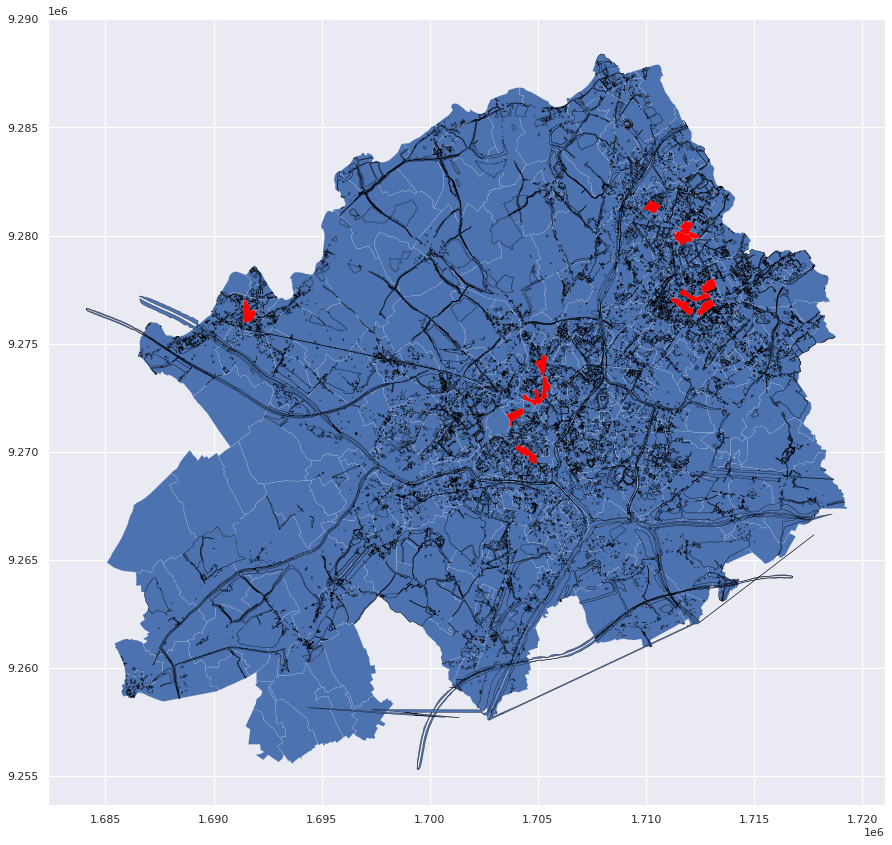

In [24]:
ax = irisMEL.plot(linewidth=0.1,figsize=(15,15))
bruit.plot(ax=ax,edgecolor='black',linewidth=0.3,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)

In [25]:
iris_data = irisMEL_parf
iris_data

INSEE_COM          NOM_COM  IRIS  CODE_IRIS  \
729      59017      Armentières  0402  590170402   
839      59350            Lille  0205  593500205   
845      59350            Lille  0119  593500119   
981      59368     La Madeleine  0301  593680301   
985      59378  Marcq-en-Barœul  0202  593780202   
986      59368     La Madeleine  0202  593680202   
1066     59599        Tourcoing  1001  595991001   
1091     59512          Roubaix  0504  595120504   
1094     59599        Tourcoing  0503  595990503   
1096     59599        Tourcoing  0801  595990801   
1098     59512          Roubaix  0602  595120602   
1116     59512          Roubaix  0603  595120603   
1148     59512          Roubaix  0402  595120402   

                           NOM_IRIS TYP_IRIS  \
729             Centre République 2        H   
839                   Vieux Lille 5        H   
845                 Lille Centre 19        H   
981   Pompidou-Nouvelle Madeleine 1        H   
985                   Pont de Marcq        H   
986                        Centre 2        H   
1066                    Belencontre        H   
1091                        Trichon        H   
1094                           Gare        H   
1096                Tilleul-Guisnes        H   
1098                  Nations Unies        H   
1116                        Anseele        H   
1148                Hommelet Centre        H   

                                               geometry  index_right  \
729   POLYGON ((1691458.251 9275994.422, 1691444.775...            0   
839   POLYGON ((1703708.801 9271162.978, 1703707.502...            0   
845   POLYGON ((1704006.929 9270104.011, 1703983.368...            0   
981   POLYGON ((1704332.671 9272401.559, 1704331.572...            0   
985   POLYGON ((1705221.866 9273542.213, 1705218.671...            0   
986   POLYGON ((1705278.925 9272434.048, 1705273.834...            0   
1066  POLYGON ((1709876.861 9281260.666, 1709881.352...            0   
1091  POLYGON ((1711428.039 9276791.993, 1711392.299...            0   
1094  POLYGON ((1711583.941 9279556.647, 1711567.566...            0   
1096  POLYGON ((1711587.863 9280166.941, 1711606.224...            0   
1098  POLYGON ((1711548.864 9277310.282, 1711556.348...            0   
1116  POLYGON ((1712469.947 9276274.438, 1712452.376...            0   
1148  POLYGON ((1712664.271 9277305.625, 1712654.785...            0   

              name  
729   mel_boundary  
839   mel_boundary  
845   mel_boundary  
981   mel_boundary  
985   mel_boundary  
986   mel_boundary  
1066  mel_boundary  
1091  mel_boundary  
1094  mel_boundary  
1096  mel_boundary  
1098  mel_boundary  
1116  mel_boundary  
1148  mel_boundary

In [26]:
dfe_bike = dfe[dfe['bicycle']>0].copy(deep=True)
dfe_bike = dfe_bike[dfe_bike['bicycle_safety']>0] # ensure the safety
dfe_bike = dfe_bike.dropna()
dfe_bike = dfe_bike[~(dfe_bike.is_empty | dfe_bike.geometry.isna())]

In [27]:
def ckdnearest(gdfA, gdfB, gdfB_cols=['g']):
    A = np.concatenate([np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    return dfe_bike.iloc[idx].name

In [28]:
# from tqdm import tqdm
# nearest = []
# for i in tqdm(range(iris_data.shape[0])):
#     iris = iris_data.iloc[i]
#     x = iris['geometry']
#     s = x.simplify(50, preserve_topology=True)
#     iris_df = pd.DataFrame.from_records(s.exterior.coords, columns=['longitude','latitude'])
#     iris_df = gpd.GeoDataFrame(iris_df, geometry=gpd.points_from_xy(iris_df.longitude, iris_df.latitude), crs=3950)
#     B = [np.array(geom.coords) for geom in dfe_bike.geometry.to_list()]
#     B_ix = tuple(itertools.chain.from_iterable([itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
#     B = np.concatenate(B)
#     ckd_tree = cKDTree(B)
#     edge_ids_steps = []
#     for row in iris_df.itertuples():
#         name = ckdnearest(gpd.GeoDataFrame([list(row)], columns=row._fields), dfe_bike)
#         edge_ids_steps.append(name)
#     iris_df['nearest'] = edge_ids_steps
#     # nearest.append(iris_df.nearest.to_list()[0])
#     nearest.extend(iris_df.nearest.to_list())

In [29]:
average_speed_kph = 15
average_speed_mps = average_speed_kph * 1000 / 3600
dfe_bike['time'] = dfe_bike.length / average_speed_mps

In [30]:
import networkx as nx
# Créer le graphe dirigé
g = nx.DiGraph()

# Ajouter les arêtes au graphe avec les propriétés time
edgelist = dfe_bike.reset_index()[['u','v', 'time', 'edge_id']].values
for u, v, time, edge_id in edgelist:
    g.add_edge(u, v, time=time, edge_id=edge_id)

In [31]:
# from tqdm import tqdm
# # Get reachable ages from the POI
# reachable = []
# for loc in tqdm(nearest):
#     path = nx.single_source_dijkstra_path_length(g, dfe_bike.loc[loc].u, weight='time', cutoff=15*60).keys()    
#     for key in path:
#         for tmp in path:
#             if key != tmp:
#                 if g.has_edge(key,tmp):
#                     edge = g[key][tmp]['edge_id']
#                     if edge not in reachable:
#                         reachable.append(edge)

In [32]:
#bike_15 =  dfe_bike.loc[reachable].copy(deep=True)

NameError: name 'reachable' is not defined

In [ ]:
#bike_15.plot()

In [33]:
#bike_15 = bike_15.to_parquet('sauv_bike_15.parquet')

<AxesSubplot:>

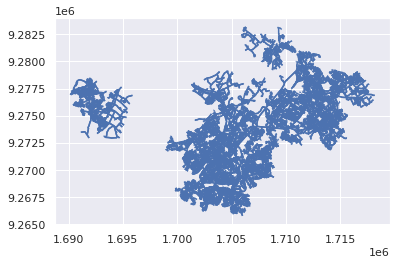

In [34]:
gpd.read_parquet('sauv_bike_25.parquet').plot()

<AxesSubplot:>

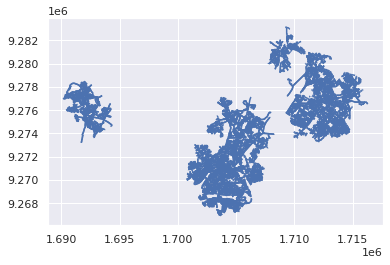

In [35]:
bike_15 = gpd.read_parquet('sauv_bike_15.parquet')
gpd.read_parquet('sauv_bike_15.parquet').plot()

<AxesSubplot:>

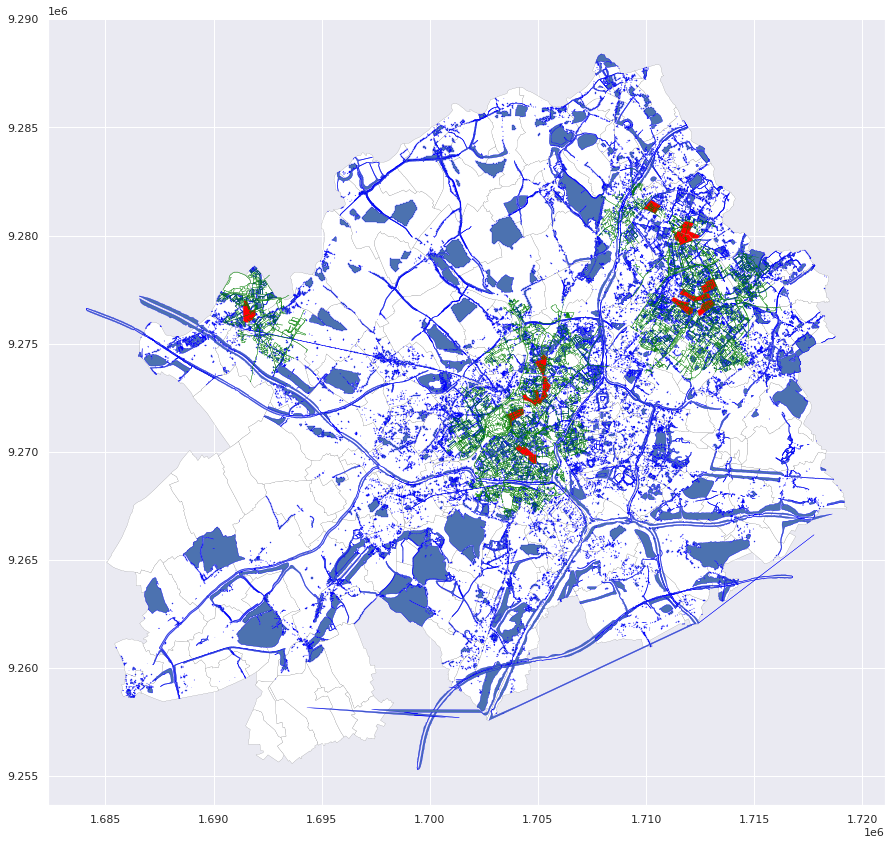

In [36]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
bruit.plot(ax=ax,edgecolor='blue',linewidth=0.3,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
bike_15.plot(ax=ax,edgecolor='green',linewidth=0.3)

### Noise filter (NIELS)

In [37]:
filtre = gpd.sjoin(bike_15,bruit, how ='left', predicate = 'intersects')
filtre = filtre[filtre['index_right'].isna()]

<AxesSubplot:>

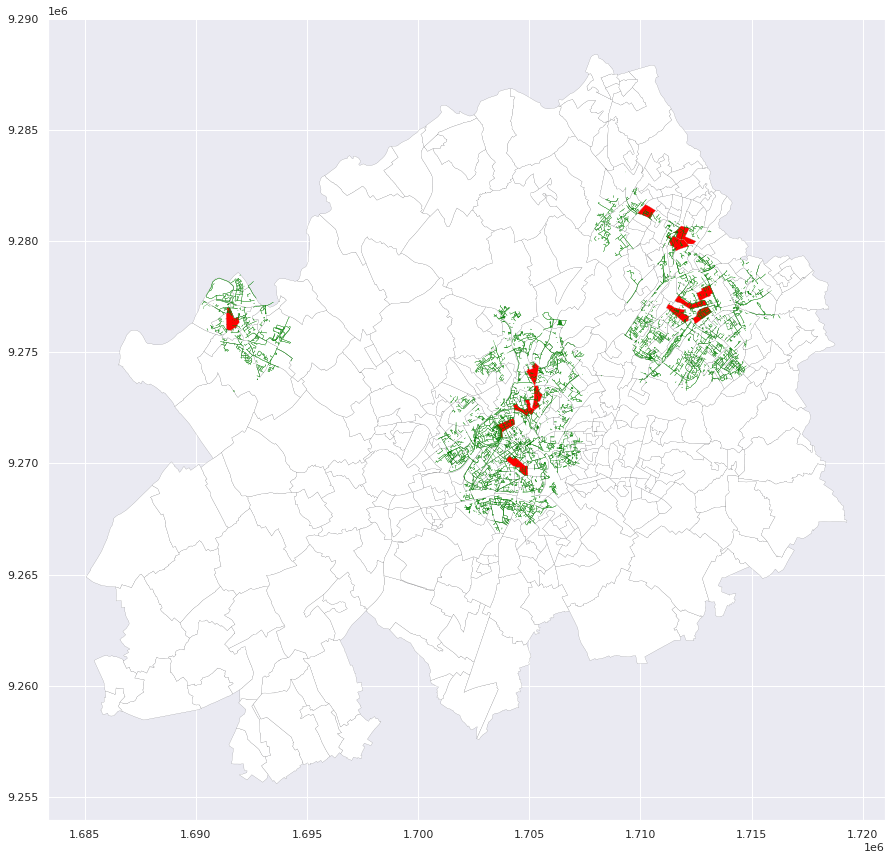

In [38]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
filtre.plot(ax=ax,edgecolor='green',linewidth=0.3)

## filter the dangerous roads (...)

<AxesSubplot:>

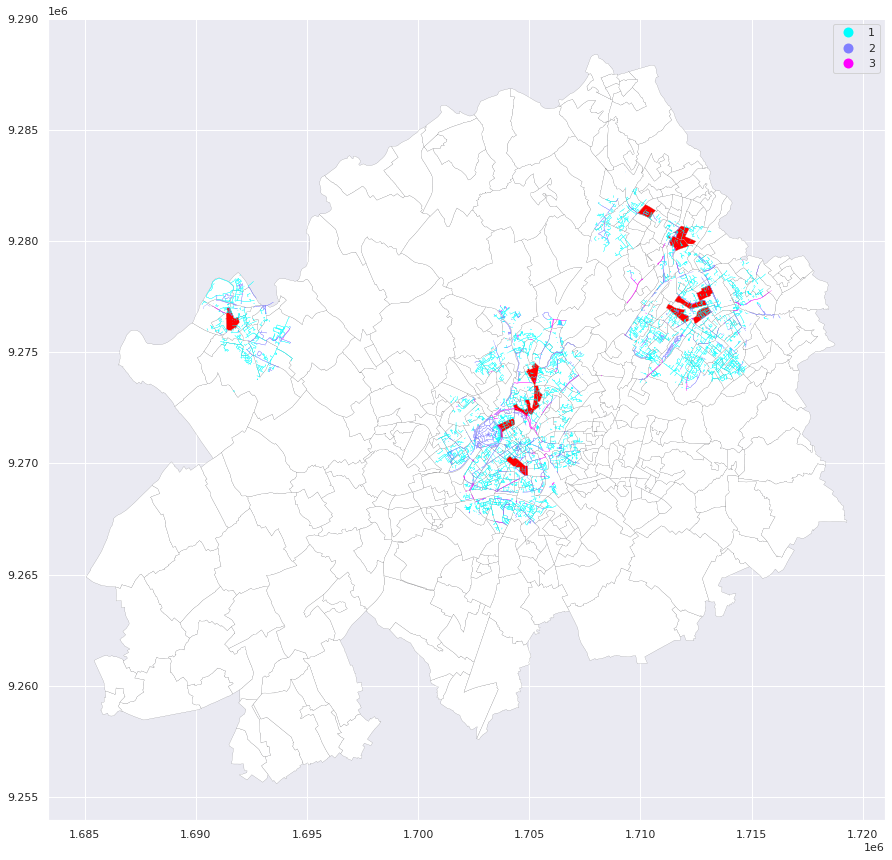

In [39]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
filtre[filtre.bicycle == 1].plot(ax=ax,column='bicycle_safety', cmap='cool', categorical=True, linewidth=0.3, figsize=(20,15), legend= True)

In [40]:
safe_bike2 = filtre[filtre['bicycle_safety'] == 2  ]
safe_bike3 = filtre[filtre['bicycle_safety'] == 3  ]

<AxesSubplot:>

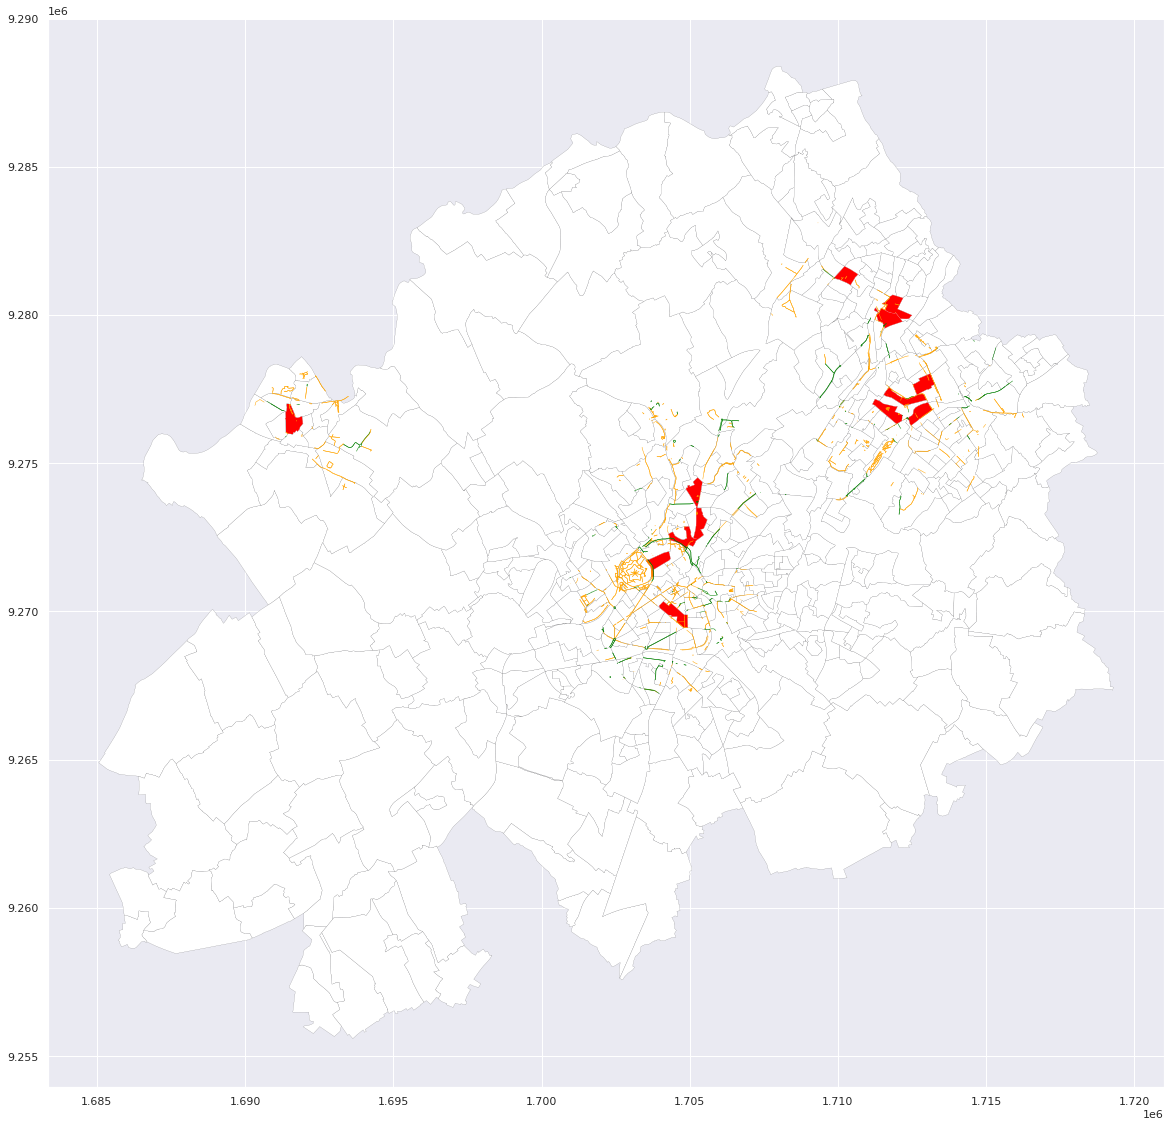

In [41]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(20,20))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
safe_bike2.plot(ax=ax, edgecolor='orange', linewidth=0.5)
safe_bike3.plot(ax=ax, edgecolor='green', linewidth=0.5)

<AxesSubplot:>

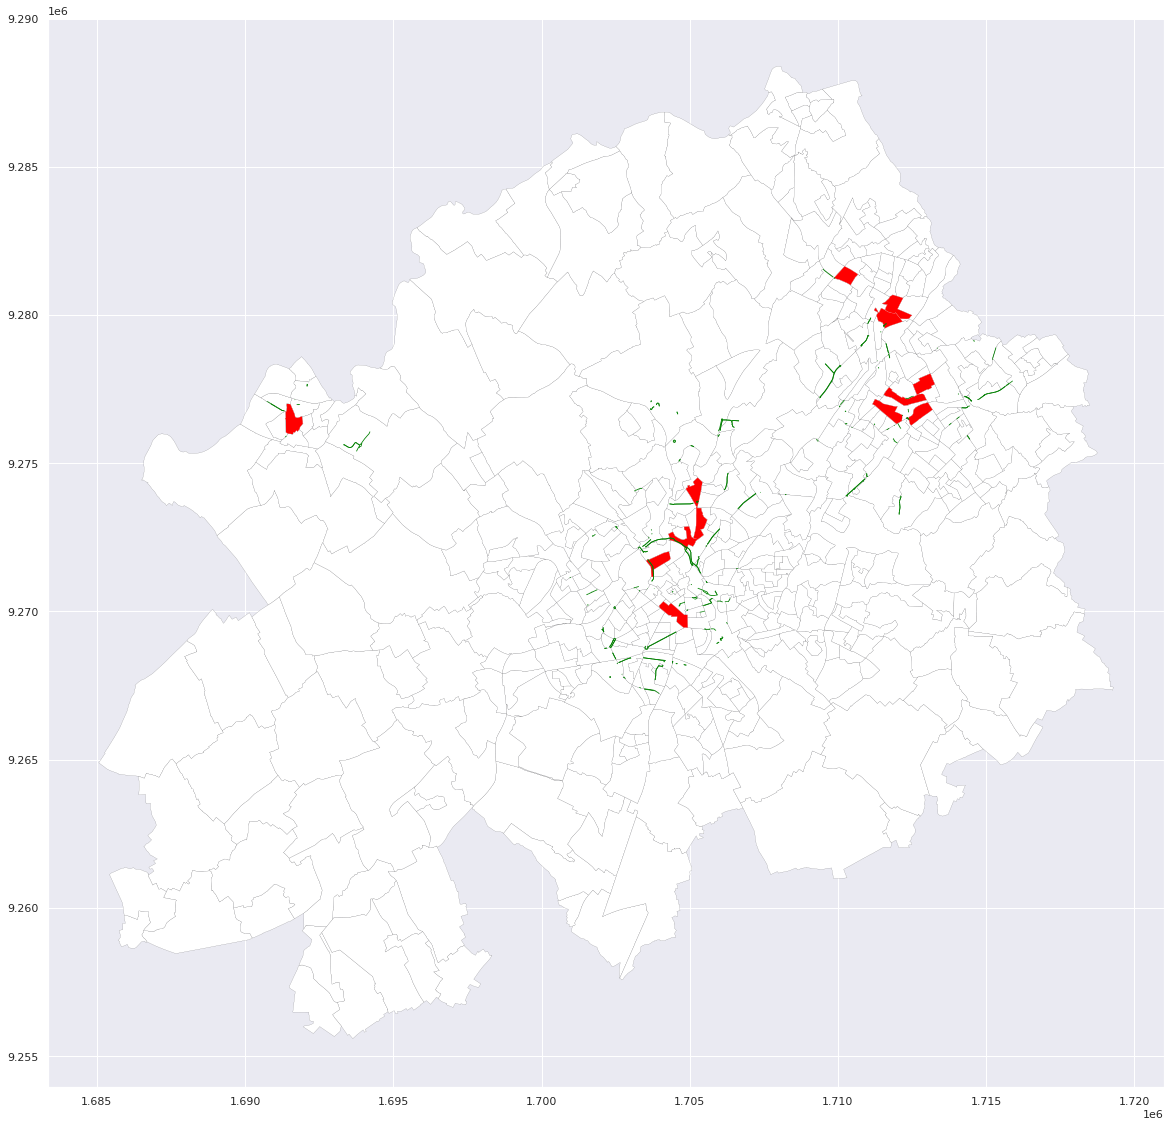

In [42]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(20,20))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
safe_bike3.plot(ax=ax, edgecolor='green', linewidth=0.8)

## find the best point to put the shop (...)

In [43]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

safe_bike3['midpoint'] = safe_bike3['geometry'].centroid
milieux = gpd.GeoDataFrame(geometry=safe_bike3['midpoint'])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

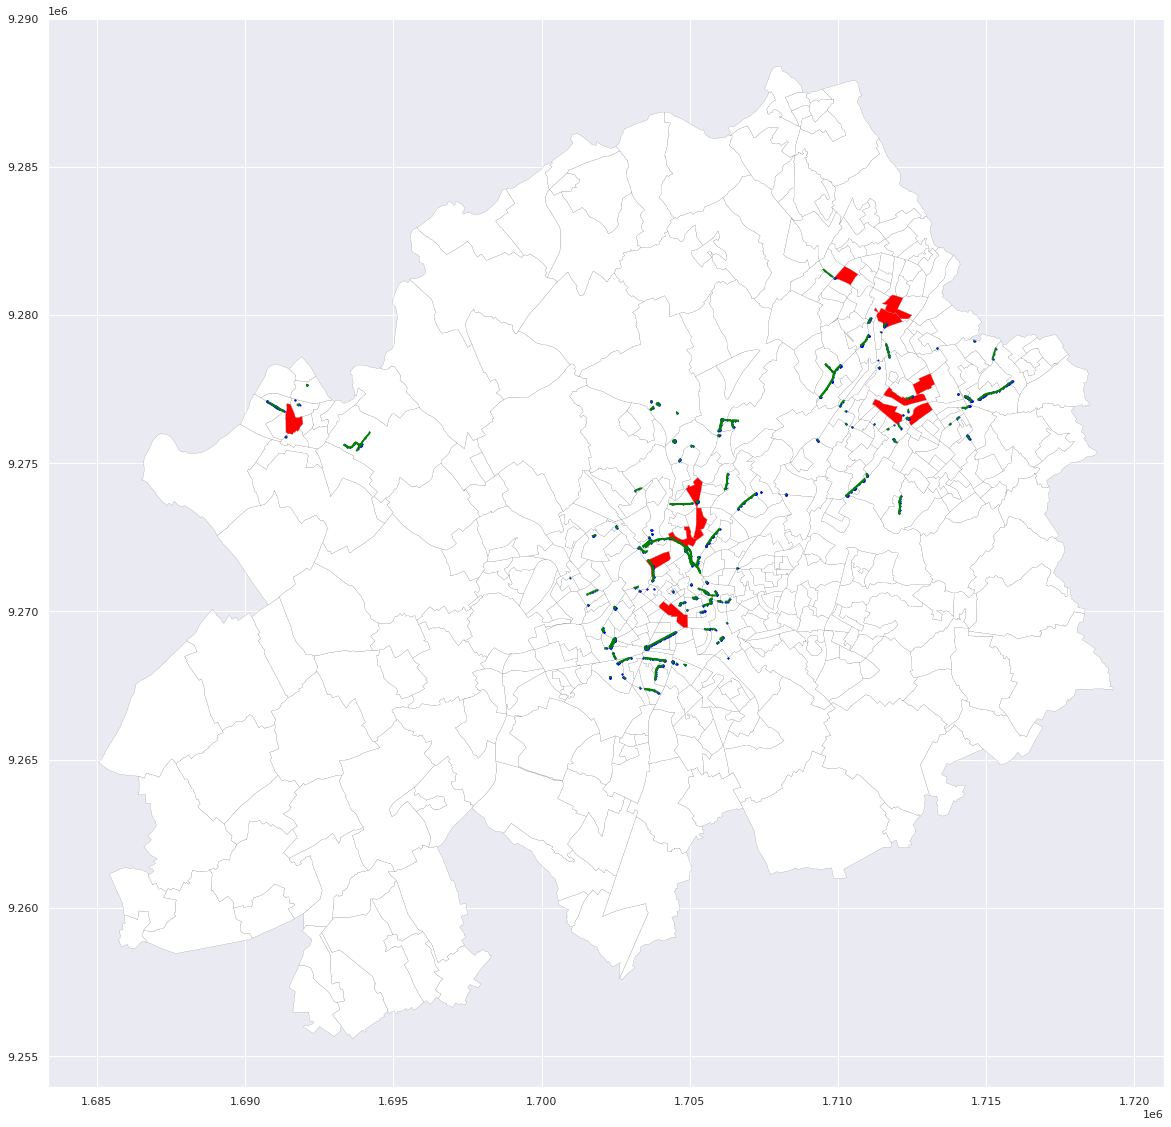

In [44]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(20,20))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
safe_bike3.plot(ax=ax, edgecolor='green', linewidth=2)
milieux.plot(ax=ax, color='blue', markersize=1)

In [45]:
iris_parf_subset = iris_emploi[['NOM_IRIS', 'densite_emplois', 'population_densite']]
irisMEL = irisMEL.merge(iris_parf_subset, on='NOM_IRIS', how='left')

In [46]:
import geopandas as gpd
from shapely.ops import nearest_points

# Charger vos GeoDataFrames (remplacez 'points.geojson' et 'iris.geojson' par vos propres noms de fichiers)
gdf_points = milieux
gdf_iris = irisMEL_parf
# Créer un dictionnaire pour stocker les paires de points et d'iris les plus proches
nearest_dict = {}

# Itérer sur chaque point et trouver l'iris le plus proche
for point in gdf_points.itertuples():
    nearest_iris = min(gdf_iris.itertuples(), key=lambda iris: point.geometry.distance(iris.geometry))
    nearest_dict[point.Index] = nearest_iris.Index

# Créer une colonne 'nearest_iris' dans le GeoDataFrame des points
gdf_points['nearest_iris'] = gdf_points.index.map(nearest_dict)

# Fusionner avec le GeoDataFrame des iris pour récupérer les informations sur l'iris le plus proche
result = gdf_points.merge(gdf_iris, left_on='nearest_iris', right_index=True, suffixes=('_point', '_iris'))

# Calculer la distance entre chaque point et son iris le plus proche
result['distance'] = result.apply(lambda row: row.geometry_point.distance(row.geometry_iris), axis=1)

# Créer un GeoDataFrame à partir des résultats
gdf_result = gpd.GeoDataFrame(result, geometry='geometry_point')

<AxesSubplot:>

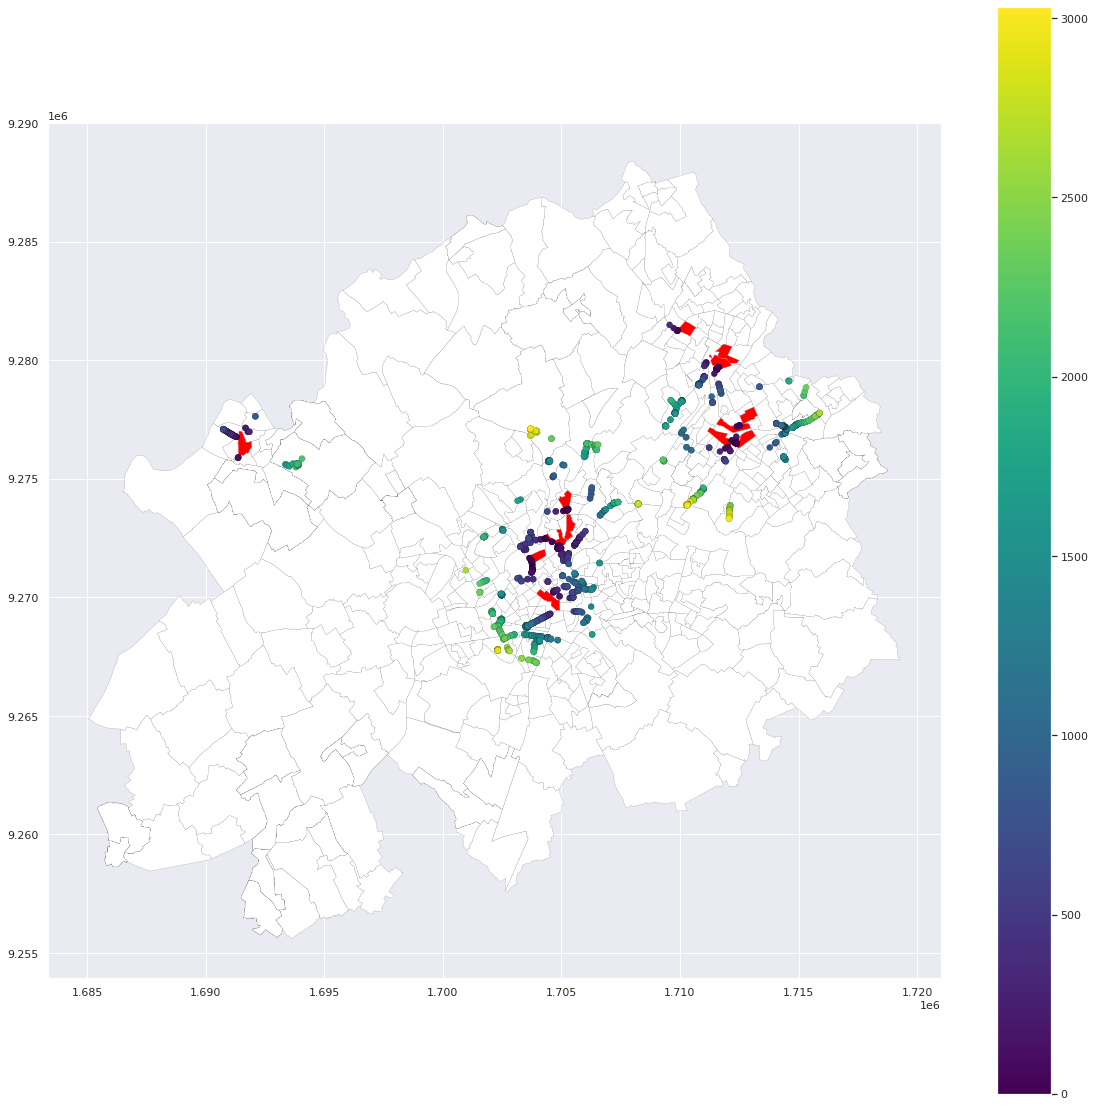

In [47]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(20,20))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
#safe_bike3.plot(ax=ax, edgecolor='green', linewidth=2)
gdf_result.plot(ax=ax, column='distance',edgecolor='black',linewidth=0.1, cmap='viridis', markersize=40, legend=True)

<AxesSubplot:>

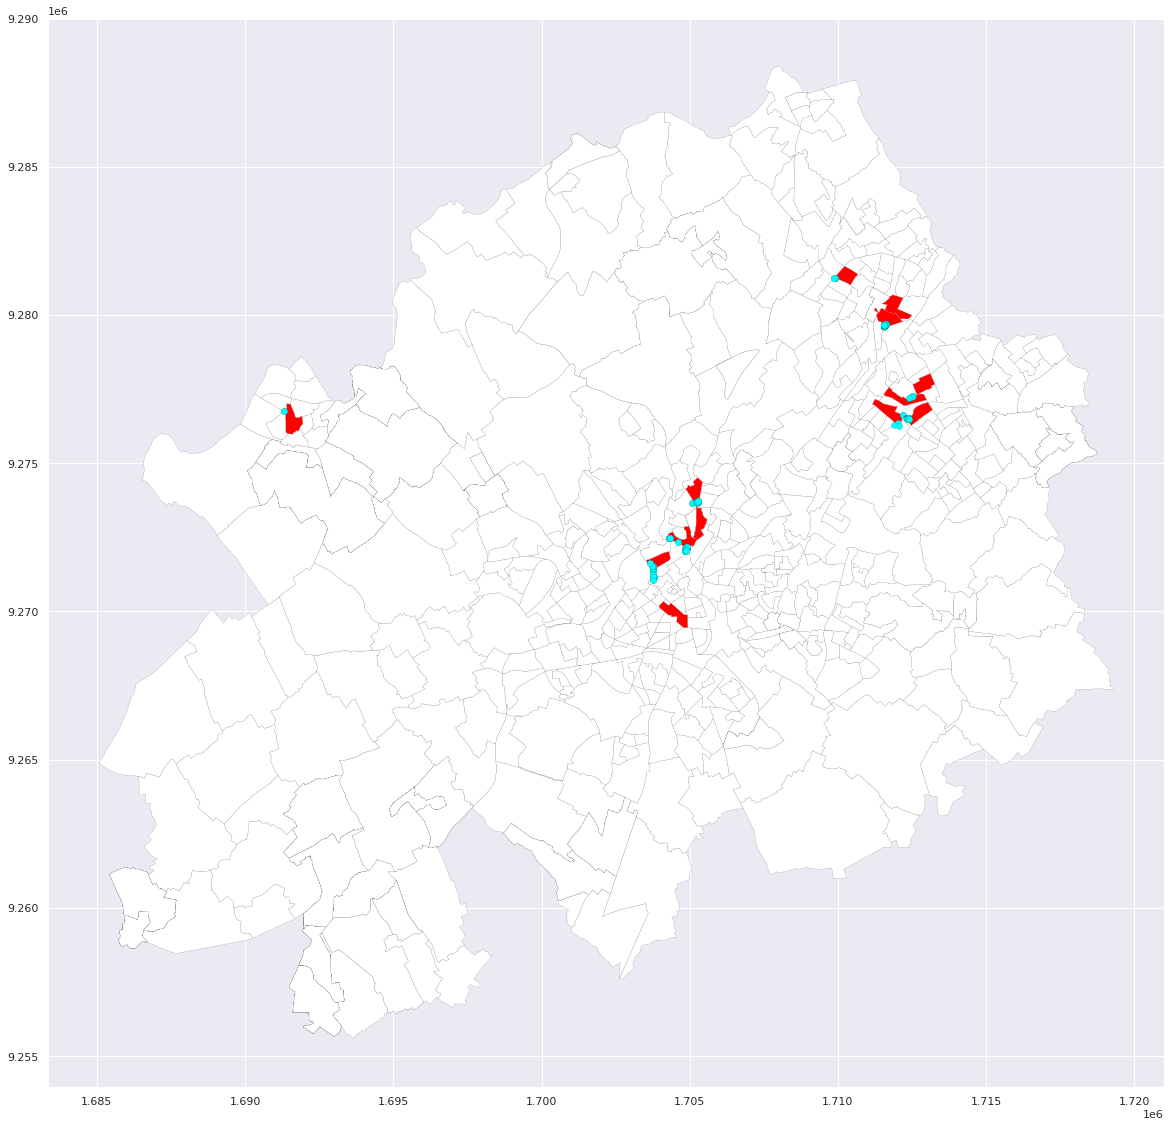

In [48]:
meilleur_points = gdf_result[gdf_result['distance'] <=100]


ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(20,20))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
#safe_bike3.plot(ax=ax, edgecolor='green', linewidth=2)
meilleur_points.plot(ax=ax,edgecolor='black',linewidth=0.1, color='cyan', markersize=40, legend=True)

In [49]:
import geopandas as gpd
from sklearn.cluster import DBSCAN
from shapely.geometry import Point

# Charger votre GeoDataFrame des points (remplacez 'points.geojson' par votre propre nom de fichier)
gdf_points = meilleur_points

# Spécifier la distance minimale entre les points pour les considérer comme proches
distance_threshold = 500  # À ajuster selon vos besoins

# Convertir les coordonnées des points en un tableau numpy pour l'algorithme de clustering
points_array = gdf_points['geometry_point'].apply(lambda geom: [geom.x, geom.y]).to_list()

# Utiliser DBSCAN pour effectuer le clustering spatial
dbscan = DBSCAN(eps=distance_threshold, min_samples=1)
gdf_points['cluster'] = dbscan.fit_predict(points_array)

# Sélectionner un point par cluster (le premier point de chaque cluster)
unique_points = gdf_points.groupby('cluster').first()

# Réinitialiser l'index du GeoDataFrame résultant
unique_points = unique_points.reset_index(drop=True)



/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

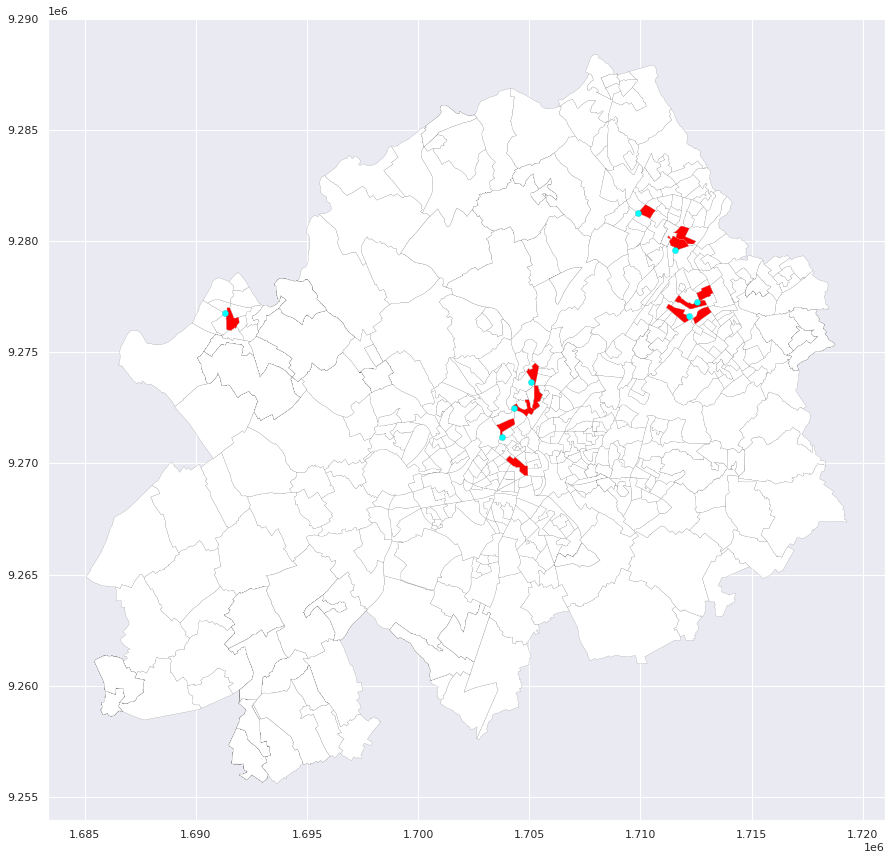

In [51]:
ax = irisMEL.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
irisMEL_parf.plot(ax=ax,color='red',linewidth=0.1)
#safe_bike3.plot(ax=ax, edgecolor='green', linewidth=2)
unique_points.plot(ax=ax,edgecolor='black',linewidth=0.1, color='cyan', markersize=40, legend=True)